In [1]:
import time
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import os

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.4.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [12]:
from google.colab import drive
drive.mount('/content/drive/')  # 将google硬盘挂载在/comtent/drive/目录上面

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
path  = '/content/drive/My Drive/Colab Notebooks/glasses_classification'
os.chdir(path)
import sys
sys.path.insert(0, '.')
from mobilenetv2_full import mobilenetv2
from logger import Logger,savefig

#!unzip glasses_training_data.zip

In [14]:
#####build the network model
model = mobilenetv2(num_classes=2, width_mult=0.1)
print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
#打印模型架构
#print(model)

    Total params: 0.08M


In [0]:
#a = torch.rand([1,3,64,64])
#outputs = model(a)
#print(outputs)

tensor([[-0.6890, -0.1649]], grad_fn=<AddmmBackward>)


In [15]:
###load the pretrained weights，下载的预训练模型
pretrained_path = 'weights/mobilenetv2_0.1-7d1d638a.pth'

print("Initializing the network ...")
#读入预训练模型的参数
#pytorch存储的模型一般采取存储网络参数格式，保存的格式为字典的格式，键为定义每层op的名字，值为保存的参数值

state_dict = torch.load(pretrained_path)

###去掉全链接层的权重，
#由于我们一般不会直接使用，imagenet的1000类，因此，我们需要更换网络最后的全链接层
#因此我们需要将前边几层的参数保存，最后一层重新初始化
#定义一个新的字典，将原始的参数字典，对应保存与更改
from collections import OrderedDict
new_state_dict = OrderedDict()

for k,v in state_dict.items():
    #print(k)  #打印预训练模型的键，如果发现与网络定义的键有一定的差别，可以更改对应的键值，
    #torchvision中的网络定义，采用了正则表达式，来更改键值，因为这里简单，没有再去构建正则表达式
    ##最后一层的全连接层，进行初始化
    if k.split('.')[0] == 'classifier':
        if k.split('.')[-1] == 'weights':
            v = nn.init.kaiming_normal(model.state_dict()[k], mode='fan_out')
        else:
            model.state_dict()[k][...] = 0.0
            v = model.state_dict()[k][...]
    ##得到新的与定义网络对应的预训练参数
    new_state_dict[k] = v
    #print('init,key',k)
##导入网络参数
model.load_state_dict(new_state_dict)
print("initialize the network done")

Initializing the network ...
initialize the network done


In [0]:
from torchvision import transforms, datasets
# 构建数据提取器，利用dataloader
# 利用torchvision中的transforms进行图像预处理

input_size = 64
batch_size = 64
'''
    brightness (float): How much to jitter brightness. brightness_factor
            is chosen uniformly from [max(0, 1 - brightness), 1 + brightness].
        contrast (float): How much to jitter contrast. contrast_factor
            is chosen uniformly from [max(0, 1 - contrast), 1 + contrast].
        saturation (float): How much to jitter saturation. saturation_factor
            is chosen uniformly from [max(0, 1 - saturation), 1 + saturation].
        hue(float): How much to jitter hue. hue_factor is chosen uniformly from
            [-hue, hue]. Should be >=0 and <= 0.5.
    '''
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),#随机10度以内旋转
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),#随机水平翻转
    transforms.ColorJitter(brightness=1,contrast=1,hue=0.4),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

val_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

##ImageFolder对象可以将一个文件夹下的文件构造成一类
#所以数据集的存储格式为一个类的图片放置到一个文件夹下
#然后利用dataloader构建提取器，每次返回一个batch的数据，在很多情况下，利用num_worker参数
#设置多线程，来相对提升数据提取的速度

train_dir = 'glasses_training_data/train'
train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=2)


val_dir = 'glasses_training_data/val'
val_datasets = datasets.ImageFolder(val_dir, transform=val_transforms)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True, num_workers=2)

Epoch: 0/300 || lr:0.005000 || train_loss: 0.659 || train_acc: 0.660
Epoch: 1/300 || lr:0.005000 || train_loss: 0.736 || train_acc: 0.696
Epoch: 2/300 || lr:0.005000 || train_loss: 0.697 || train_acc: 0.701
Epoch: 3/300 || lr:0.005000 || train_loss: 0.636 || train_acc: 0.751
Epoch: 4/300 || lr:0.005000 || train_loss: 0.786 || train_acc: 0.729
Epoch: 5/300 || lr:0.005000 || train_loss: 0.581 || train_acc: 0.774
Epoch: 6/300 || lr:0.005000 || train_loss: 0.615 || train_acc: 0.767
Epoch: 7/300 || lr:0.005000 || train_loss: 0.606 || train_acc: 0.747
Epoch: 8/300 || lr:0.005000 || train_loss: 0.582 || train_acc: 0.786
Epoch: 9/300 || lr:0.005000 || train_loss: 0.749 || train_acc: 0.738
val_loss: 1.687 || val_acc: 0.744
Epoch: 10/300 || lr:0.005000 || train_loss: 0.730 || train_acc: 0.778
Epoch: 11/300 || lr:0.005000 || train_loss: 0.619 || train_acc: 0.772
Epoch: 12/300 || lr:0.005000 || train_loss: 0.488 || train_acc: 0.822
Epoch: 13/300 || lr:0.005000 || train_loss: 0.475 || train_acc: 0.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


val_loss: 0.253 || val_acc: 0.902


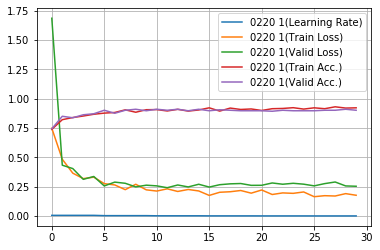

In [17]:
from torch.optim import lr_scheduler

learning_rate=0.005
max_epoch=300
val_epoch=10#每10个epoch，验证一下
save_folder='weights/'
log_folder='logs'
log_file='train_0220_2.log'


log_variable_name = ['Learning_Rate','Train_Loss','Valid_Loss','Train_Acc','Valid_Acc']
log_variable_dict = {k:0.0 for k in log_variable_name}
###日志模块
if not os.path.exists(log_folder):
    os.system('mkdir -p {}'.format(log_folder))
logger = Logger(os.path.join(log_folder, log_file), title='0220 1')
logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])

###模型放置在gpu上进行计算
if torch.cuda.is_available():
    model.cuda()

##定义优化器与损失函数
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=5e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
loss_func = nn.CrossEntropyLoss()

#每一个epoch含有多少个batch
max_batch = len(train_datasets)//batch_size
best_acc = 0#用来保存精度最高的模型
##训练max——epoch个epoch
for epoch in range(max_epoch):
    model.train()  ##在进行训练时加上train()，测试时加上eval()
    batch = 0
    train_acc = 0.0
    train_loss = 0.0
    for batch_images, batch_labels in train_dataloader:
        ##在pytorch0.4之后将Variable 与tensor进行合并，所以这里不需要进行Variable封装
        if torch.cuda.is_available():
            batch_images, batch_labels = batch_images.cuda(),batch_labels.cuda()
        
        optimizer.zero_grad() #清空梯度信息，否则在每次进行反向传播时都会累加
        out = model(batch_images)
        #print('out',out)
        loss = loss_func(out,batch_labels)
        #print('batch_labels',batch_labels)
        #print('loss',loss)
        train_loss += loss
        prediction = torch.max(out,1)[1]
        #print('prediction',prediction)

        train_correct = (prediction == batch_labels).sum()
        ##这里得到的train_correct是一个longtensor型，需要转换为float
        # print(train_correct.type())
        train_acc += train_correct
 #       print(train_acc.type())
        loss.backward()  #loss反向传播
        optimizer.step()  ##梯度更新
        
        batch+=1
        #print("Epoch: %d/%d || batch:%d/%d average_loss: %.3f || train_acc: %.2f"
        #      %(epoch, max_epoch, batch, max_batch, average_loss, train_acc))
    log_variable_dict['Learning_Rate'] = scheduler.get_lr()[0]
    log_variable_dict['Train_Loss'] = train_loss.data.item()/batch
    log_variable_dict['Train_Acc'] = train_acc.data.item()/ len(train_datasets)
    print("Epoch: %d/%d || lr:%.6f || train_loss: %.3f || train_acc: %.3f"
            %(epoch,max_epoch,log_variable_dict['Learning_Rate'], log_variable_dict['Train_Loss'],log_variable_dict['Train_Acc']))
    scheduler.step()
    
    if (epoch+1)%val_epoch==0:#val
        ##进行模型测试时，eval（）会固定下BN与Dropout的参数
        model.eval()
        eval_acc = 0.0
        val_loss = 0.0
        batch = 0
        for batch_images, batch_labels in val_dataloader:
            # print(batch_labels)
            with torch.no_grad():
                if torch.cuda.is_available():
                    batch_images, batch_labels = batch_images.cuda(), batch_labels.cuda()

            out = model(batch_images)
            loss = loss_func(out,batch_labels)
            val_loss += loss

            prediction = torch.max(out, 1)[1]
            num_correct = (prediction == batch_labels).sum()
            eval_acc += num_correct
            #print(eval_acc)
            batch += 1
        
        log_variable_dict['Valid_Loss'] = val_loss.data.item()/batch
        eval_acc = eval_acc.data.item() / len(val_datasets)
        log_variable_dict['Valid_Acc'] = eval_acc

        # append logger file
        logger.append([log_variable_dict[k] for k in log_variable_name])
        print("val_loss: %.3f || val_acc: %.3f"%(log_variable_dict['Valid_Loss'],log_variable_dict['Valid_Acc']))
        if eval_acc > best_acc:
            best_acc = eval_acc
            torch.save(model.state_dict(), os.path.join(save_folder,'best.pth'))
    ##每10epoch保存一次模型
    if (epoch+1)%10 ==0:
        torch.save(model.state_dict(), os.path.join(save_folder,'last.pth'))
logger.close()
logger.plot()
savefig(os.path.join('logs', log_file.replace('.log','.eps')))